<a href="https://colab.research.google.com/github/DarshanDinni/learn_pytorch/blob/main/02_Pytorch_multi_class_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
# Importing libraries
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [114]:
# Setting up the agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

###**Build the data**

We are building the data using `make_blog` function from `sklearn.datasets` which helps use to create n blob data points, which we can use to solve our multi class classification problem.

In [115]:
# Creating the data
X, y = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=42)
X.shape, y.shape

((1000, 2), (1000,))

In [116]:
# Printing out the data points and resp. labels
print(f'X data points: \n{X[:5]}\n')
print(f'y data labels: \n{y[:5]}\n')

X data points: 
[[-8.55503989  7.06461794]
 [-6.13753182 -6.58081701]
 [-6.32130028 -6.8041042 ]
 [ 4.18051794  1.12332531]
 [ 4.38028748  0.47002673]]

y data labels: 
[3 2 2 1 1]



###**Visualizing to understand the data**

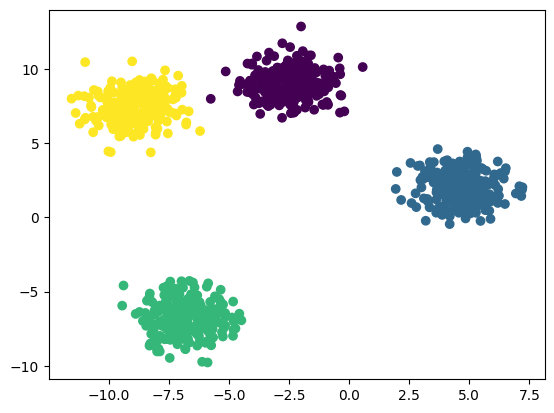

In [117]:
# Plotting the graph
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

###**Problem**
Our problem is to predict different classes.

As we have 4 classes this problem falls under multi class classification

###**Data handling**

In [118]:
# Transforming the ndarray data to tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X[:5], y[:5]

(tensor([[-8.5550,  7.0646],
         [-6.1375, -6.5808],
         [-6.3213, -6.8041],
         [ 4.1805,  1.1233],
         [ 4.3803,  0.4700]]),
 tensor([3, 2, 2, 1, 1]))

In [119]:
# Spliting the data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [120]:
# Setting the data to the agnostic code
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

###**Build model**

In [121]:
# Create a class which inherits from nn.Module
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    # This is the simpler way if building a model using nn.Sequential
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),         # layer 1 -> input features as in_features and hiddent_unit as out_features
        nn.ReLU(),                                                                # Activation function after the first layer so that we can introduce some non linearity in the data
        nn.Linear(in_features=hidden_units, out_features=hidden_units),           # layer 2 -> output of previous layer 1 as in_features and hiddent_unit as out_features
        nn.ReLU(),                                                                # Activation function after the second layer so that we can introduce some non linearity in the data
        nn.Linear(in_features=hidden_units, out_features=output_features)         # layer 3 -> output of previous layer 2 as in_features and output features as out_features
    )

  # Forward pass function that should be overwritten when inherting from the nn.Module
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(x)

In [122]:
# Instantiating the model and setting it to agnostic code
model_0 = BlobModel(2, 4, 56).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=56, bias=True)
    (1): ReLU()
    (2): Linear(in_features=56, out_features=56, bias=True)
    (3): ReLU()
    (4): Linear(in_features=56, out_features=4, bias=True)
  )
)

In [123]:
# Define the loss function
# Our problem is multiclass classification so we use cross entropy loss
loss_function = nn.CrossEntropyLoss()

# Define the optimizer - we have lot of option but we will be using the Adam optimizer for this one
# Adam optimizer's primary goal is to stabilize the training process and help neural networks converge to optimal solutions
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)

####Check model performance before training, also checking the model's output if its in the correct format as the output label

In [124]:
with torch.inference_mode():
  y_pred = model_0(X_test)

print(f'Model prediction: {y_pred[: 5]},\n Actual labels: {y_test[:5]}')

Model prediction: tensor([[-0.9655, -0.2111,  0.4900, -0.0498],
        [-0.1568, -1.0162,  1.6106,  0.2645],
        [-0.1573, -0.7087,  0.3500,  0.2100],
        [-0.6699, -0.1303,  0.2572, -0.0117],
        [-0.5829, -0.8061,  1.0527,  0.2195]], device='cuda:0'),
 Actual labels: tensor([1, 3, 2, 1, 0], device='cuda:0')


**NOTE:** `As we can see that model's prediction is not in correct format as output labels so we need to convert the prediction output to correct labels`

In [125]:
'''
The softmax function is often used as the last activation function of a neural network to normalize the output of a network to a probability distribution
over predicted output classes
'''
softmaxed_labels = torch.softmax(y_pred, dim=1)
softmaxed_labels[:5]

tensor([[0.1009, 0.2145, 0.4325, 0.2521],
        [0.1136, 0.0481, 0.6652, 0.1731],
        [0.2136, 0.1231, 0.3548, 0.3085],
        [0.1394, 0.2391, 0.3523, 0.2692],
        [0.1091, 0.0873, 0.5601, 0.2435]], device='cuda:0')

In [126]:
# Argmax is used for finding the class with the largest predicted probability
final_y_pred = torch.argmax(softmaxed_labels, dim=1)
final_y_pred[:5]

tensor([2, 2, 2, 2, 2], device='cuda:0')

As we achieved the desired format as shown above

###**Build the training loop**

In [127]:
epochs = 1000
epoch_value = []
training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []

for epoch in range(epochs):
  # Step 1: Setting the model for training phase
  model_0.train()

  # Step 2: Predicting on the training data and converting the predicted output to the correct format of labels so that it can be passed to the next step
  y_logits_train = model_0(X_train)
  y_pred_train = torch.softmax(y_logits_train, dim=1).argmax(dim=1)

  # Step 3: Calculate the loss between predicted and target output
  train_loss = loss_function(y_logits_train, y_train)

  # Calculating the accuracy of the model
  train_accuracy = accuracy_score(torch.Tensor.cpu(y_pred_train), torch.Tensor.cpu(y_train))

  # Step 4: Reset the gradient to zero after every iteration so that model can learn new things without the influence of previous gradients
  optimizer.zero_grad()

  # Step 5: Perform the gradient descent
  train_loss.backward()

  # Step 6: Take step toward the minimum loss
  optimizer.step()

  # Step 7: Setting the model for testing phase
  model_0.eval()
  with torch.inference_mode():

    # Predicting on the testing data and converting the predicted output to the correct format of labels so that it can be passed to the next step
    y_logits_test = model_0(X_test)
    y_pred_test = torch.softmax(y_logits_test, dim=1).argmax(dim=1)

    # Calculating the loss between predicted and target output
    test_loss = loss_function(y_logits_test, y_test)

    # Calculating the accuracy of the model
    test_accuracy = accuracy_score(torch.Tensor.cpu(y_pred_test), torch.Tensor.cpu(y_test))

  if epoch % 100 == 0:
    epoch_value.append(epoch)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    training_accuracy.append(train_accuracy)
    testing_accuracy.append(test_accuracy)

    print(f'Epoch {epoch}, Training loss: {train_loss}, Training accuracy: {train_accuracy * 100}, Testing loss: {test_loss}, Testing accuracy: {test_accuracy * 100}')

Epoch 0, Training loss: 1.5962579250335693, Training accuracy: 17.375, Testing loss: 0.6263375282287598, Testing accuracy: 75.5
Epoch 100, Training loss: 0.0011022723047062755, Training accuracy: 100.0, Testing loss: 0.00034463260089978576, Testing accuracy: 100.0
Epoch 200, Training loss: 0.0008236875873990357, Training accuracy: 100.0, Testing loss: 0.0001821684854803607, Testing accuracy: 100.0
Epoch 300, Training loss: 0.0005353966844268143, Training accuracy: 100.0, Testing loss: 6.870271317893639e-05, Testing accuracy: 100.0
Epoch 400, Training loss: 0.00030435671214945614, Training accuracy: 100.0, Testing loss: 2.1796060536871664e-05, Testing accuracy: 100.0
Epoch 500, Training loss: 0.0001622033305466175, Training accuracy: 100.0, Testing loss: 7.940523573779501e-06, Testing accuracy: 100.0
Epoch 600, Training loss: 7.982333772815764e-05, Training accuracy: 100.0, Testing loss: 3.5532145830075024e-06, Testing accuracy: 100.0
Epoch 700, Training loss: 4.0381313738180324e-05, Tr

In [128]:
# As we can see that our model is not learning over 100 epoch then there must be some issue
# To understand this lets visualize the prediction

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

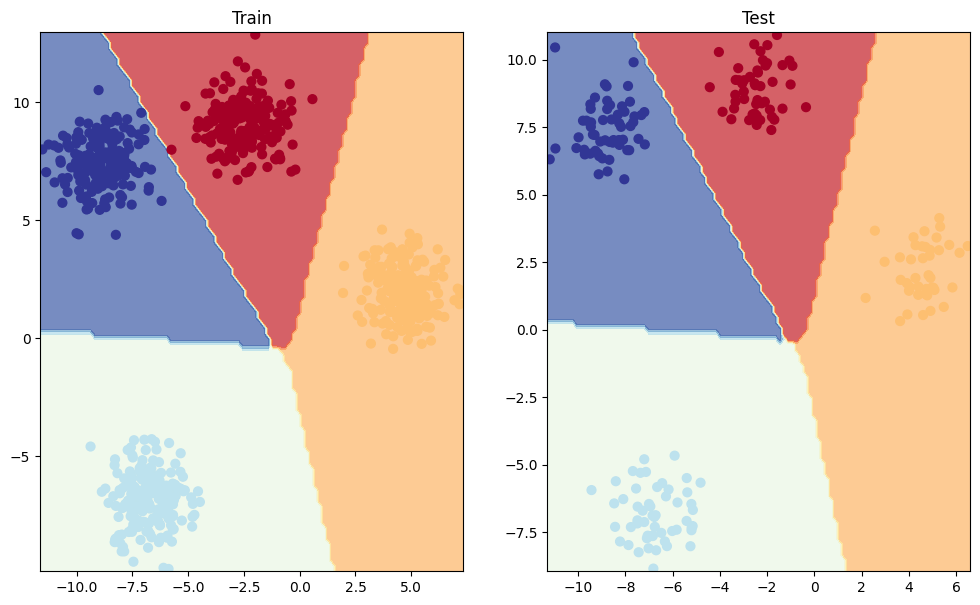

In [130]:
# Lets plot the graph
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

plt.show()